# Ансамблевые методы

Методы ансамблей — это мета-алгоритмы, которые комбинируют несколько техник машинного обучения в одну предсказательную модель с целью уменьшения дисперсии (бэггинг), смещения (бустинг) или улучшения предсказаний (стэкинг). Методы ансамблей можно разделить на две группы: *последовательные* методы ансамблей, где базовые обучающие модели создаются последовательно (например, AdaBoost), и *параллельные* методы ансамблей, где базовые обучающие модели создаются параллельно (например, Random Forest). Основная мотивация последовательных методов заключается в использовании зависимости между базовыми обучающими моделями, поскольку общая производительность может быть улучшена за счет увеличения веса ранее неправильно размеченных примеров. Основная мотивация параллельных методов заключается в использовании независимости между базовыми обучающими моделями, поскольку ошибка может быть значительно уменьшена за счет усреднения.

Большинство методов ансамблей используют один базовый алгоритм обучения для создания однородных базовых обучающих моделей, т.е. моделей одного типа, что приводит к *однородным ансамблям*. Существуют также методы, которые используют гетерогенные обучающие модели, т.е. модели разных типов, что приводит к *гетерогенным ансамблям*. Чтобы методы ансамблей были более точными, чем любой из их индивидуальных членов, базовые обучающие модели должны быть как можно более точными и как можно более разнообразными.

### Bagging

Бэггинг (Bagging) означает агрегацию с использованием бутстрепа. Один из способов уменьшить дисперсию оценки — это усреднить несколько оценок. Например, мы можем обучить $M$   различных деревьев   $f_m$ на разных подмножествах данных (выбранных случайным образом с возвращением) и вычислить ансамбль:
\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}



Бэггинг использует бутстреп-выборку для получения подмножеств данных для обучения базовых моделей. Для агрегации выходов базовых моделей бэггинг использует голосование для классификации и усреднение для регрессии.

In [1]:
# Включаем отображение графиков в Jupyter Notebook
%matplotlib inline

# Импортируем необходимые библиотеки
import itertools  # Для работы с итерациями
import numpy as np  # Для работы с массивами и математическими операциями

import seaborn as sns  # Для визуализации данных
import matplotlib.pyplot as plt  # Для построения графиков
import matplotlib.gridspec as gridspec  # Для управления макетом графиков

from sklearn import datasets  # Для загрузки наборов данных из библиотеки scikit-learn

# Импортируем классификаторы из библиотеки scikit-learn
from sklearn.tree import DecisionTreeClassifier  # Дерево решений
from sklearn.neighbors import KNeighborsClassifier  # K-ближайших соседей
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.ensemble import RandomForestClassifier  # Случайный лес

# Импортируем класс для бэггинга
from sklearn.ensemble import BaggingClassifier  
# Импортируем функции для оценки модели и разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import cross_val_score, train_test_split  

# Импортируем функции для построения кривых обучения и визуализации решений
from mlxtend.plotting import plot_learning_curves  
from mlxtend.plotting import plot_decision_regions  

# Устанавливаем фиксированное значение семени генератора случайных чисел для воспроизводимости результатов
np.random.seed(0)


In [5]:
# Загружаем набор данных "Ирисы" из библиотеки scikit-learn
iris = datasets.load_iris()

# Выбираем первые две характеристики (петли и ширина) как входные данные X,
# а целевые метки (классы) как y
X, y = iris.data[:, 0:2], iris.target

# Создаем классификатор дерева решений с критерием "энтропия" и максимальной глубиной 1
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)

# Создаем классификатор K-ближайших соседей с одним соседним элементом
clf2 = KNeighborsClassifier(n_neighbors=1)

# Создаем бэггинг-классификатор на основе дерева решений
# n_estimators — количество базовых классификаторов
# max_samples — максимальная доля обучающих выборок для каждого классификатора
# max_features — максимальная доля признаков для каждого классификатора
bagging1 = BaggingClassifier(estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)

# Создаем бэггинг-классификатор на основе K-ближайших соседей с аналогичными параметрами
bagging2 = BaggingClassifier(estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Точность: 0.63 (+/- 0.02) [Дерево решений]
Точность: 0.69 (+/- 0.02) [K-NN]
Точность: 0.67 (+/- 0.06) [Бэггинг с деревом]
Точность: 0.64 (+/- 0.06) [Бэггинг K-NN]


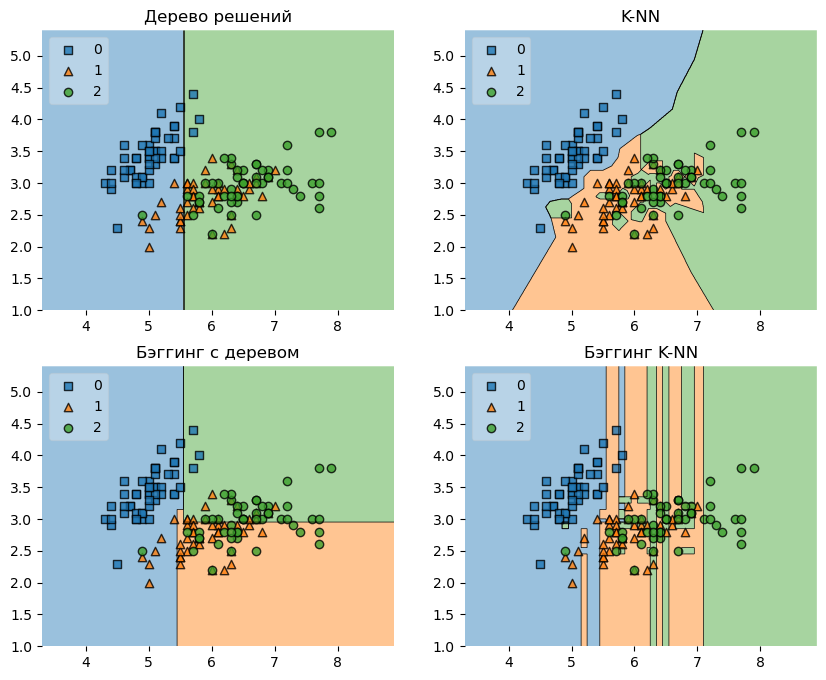

In [6]:
# Названия для классификаторов
label = ['Дерево решений', 'K-NN', 'Бэггинг с деревом', 'Бэггинг K-NN']

# Список классификаторов для перебора
clf_list = [clf1, clf2, bagging1, bagging2]

# Создаем фигуру для графиков с заданным размером
fig = plt.figure(figsize=(10, 8))

# Определяем сетку для подграфиков (2 строки и 2 столбца)
gs = gridspec.GridSpec(2, 2)

# Генерируем все возможные позиции для подграфиков
grid = itertools.product([0, 1], repeat=2)

# Перебираем классификаторы, их названия и позиции в сетке
for clf, label, grd in zip(clf_list, label, grid):        
    # Выполняем кросс-валидацию и получаем оценки точности
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    # Выводим среднюю точность и стандартное отклонение
    print("Точность: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    # Обучаем классификатор на всех данных
    clf.fit(X, y)
    
    # Создаем подграфик по заданной позиции
    ax = plt.subplot(gs[grd[0], grd[1]])
    
    # Рисуем области решений для текущего классификатора
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    
    # Устанавливаем заголовок для подграфика
    plt.title(label)

# Отображаем все графики
plt.show()

На приведенном выше рисунке показаны границы решений классификаторов дерева решений и k-NN, а также их ансамбли с бэггингом, примененные к набору данных Iris. Дерево решений показывает границы, параллельные осям, в то время как ближайшие соседи с $k=1$ плотно подстраиваются под точки данных. Ансамбли с бэггингом были обучены с использованием $10$ базовых оценщиков с $0.8$ подвыборкой обучающих данных и $0.8$ подвыборкой признаков. Ансамбль бэггинга дерева решений достиг более высокой точности по сравнению с ансамблем бэггинга k-NN, потому что k-NN менее чувствительны к возмущениям в обучающих выборках и поэтому называются *стабильными обучающими алгоритмами*. Комбинирование стабильных обучающих алгоритмов менее выгодно, поскольку ансамбль не поможет улучшить обобщающую способность.

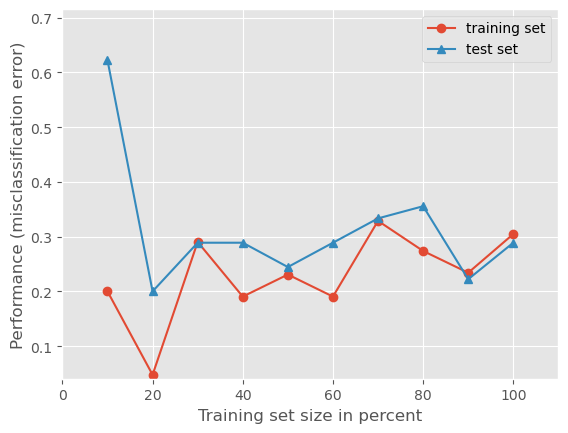

In [7]:
# Импортируем необходимые библиотеки
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Разделяем данные на обучающую и тестовую выборки (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создаем новую фигуру для графика
plt.figure()

# Строим кривые обучения для обучающей и тестовой выборок с использованием модели bagging1
# print_model=False - не выводим модель на экран, style='ggplot' - стиль графика
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')

# Отображаем график
plt.show()

На рисунке выше показаны кривые обучения для ансамбля деревьев с бэггингом. Мы можем видеть среднюю ошибку $0.3$ на обучающих данных и U-образную кривую ошибки для тестовых данных. Наименьший разрыв между ошибками на обучающей и тестовой выборках наблюдается при размере обучающей выборки около $80%$.

In [8]:
# Размер ансамбля
num_est = map(int, np.linspace(1, 100, 20))  # Создаем последовательность из 20 значений от 1 до 100
bg_clf_cv_mean = []  # Список для хранения средних значений точности кросс-валидации
bg_clf_cv_std = []   # Список для хранения стандартных отклонений точности кросс-валидации

for n_est in num_est:  # Проходим по каждому значению размера ансамбля
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)  
    # Создаем классификатор с бэггингом, используя базовый классификатор clf1 и текущее значение n_estimators
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')  
    # Выполняем кросс-валидацию и получаем оценки точности на 3 фолдах
    bg_clf_cv_mean.append(scores.mean())  # Добавляем среднее значение точности в список
    bg_clf_cv_std.append(scores.std())    # Добавляем стандартное отклонение точности в список

TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [ ]:
import numpy as np  # Импортируем библиотеку NumPy для работы с массивами
import matplotlib.pyplot as plt  # Импортируем Matplotlib для построения графиков
from sklearn.ensemble import BaggingClassifier  # Импортируем класс BaggingClassifier из библиотеки sklearn
from sklearn.model_selection import cross_val_score  # Импортируем функцию для кросс-валидации

# Размер ансамбля
num_est = list(map(int, np.linspace(1, 100, 20)))  # Создаем список из 20 значений от 1 до 100 (включительно), преобразуя их в целые числа
bg_clf_cv_mean = []  # Список для хранения средних значений точности кросс-валидации
bg_clf_cv_std = []   # Список для хранения стандартных отклонений точности кросс-валидации

# Проходим по каждому значению количества деревьев в ансамбле
for n_est in num_est:    
    # Создаем классификатор Bagging с заданным количеством деревьев (n_estimators)
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    
    # Выполняем кросс-валидацию и получаем оценки точности
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    
    # Сохраняем среднее значение и стандартное отклонение оценок в соответствующие списки
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

# Проверяем длины списков, чтобы убедиться, что они совпадают
print(len(num_est), len(bg_clf_cv_mean), len(bg_clf_cv_std))

In [ ]:
plt.figure()  # Создаем новую фигуру для графика
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)  
# Строим график с ошибками: num_est - ось X, bg_clf_cv_mean - ось Y, bg_clf_cv_std - ошибки по Y
# 'c' - цвет линии, 'fmt' - формат точки, 'capsize' - размер "шапочек" на концах ошибок

for cap in caps:  # Проходим по всем "шапочкам" на концах ошибок
    cap.set_markeredgewidth(1)  # Устанавливаем ширину границы "шапочек"

plt.ylabel('Accuracy')  # Подпись оси Y
plt.xlabel('Ensemble Size')  # Подпись оси X
plt.title('Bagging Tree Ensemble')  # Заголовок графика
plt.show()  # Отображаем график

На рисунке выше показано, как точность тестирования улучшается с увеличением размера ансамбля. На основе результатов кросс-валидации мы можем увидеть, что точность увеличивается до примерно $10$ базовых оценщиков, а затем достигает плато. Таким образом, добавление базовых оценщиков сверх $10$ лишь увеличивает вычислительную сложность без прироста точности для набора данных Iris.

Распространённым классом ансамблевых алгоритмов являются леса рандомизированных деревьев. В **случайных лесах** каждое дерево в ансамбле строится на основе выборки, взятой с возвратом (т.е. бутстрэп-выборки) из обучающего набора. Кроме того, вместо использования всех признаков выбирается случайное подмножество признаков, что дополнительно рандомизирует дерево. В результате, смещение леса немного увеличивается, но благодаря усреднению менее коррелированных деревьев его дисперсия уменьшается, что приводит к созданию более качественной модели в целом.

В алгоритме **экстремально рандомизированных деревьев** (**extremely randomized trees**) случайность делает ещё один шаг вперёд: пороги разделения рандомизируются. Вместо того чтобы искать наиболее дискриминационный порог, пороги выбираются случайным образом для каждого кандидата-признака, и лучший из этих случайно сгенерированных порогов выбирается в качестве правила разделения. Это обычно позволяет немного снизить дисперсию модели, ценой незначительного увеличения смещения.

### Boosting

Бустинг относится к семейству алгоритмов, которые способны преобразовывать слабые обучающие модели в сильные. Основной принцип бустинга заключается в том, чтобы подгонять последовательность слабых моделей (моделей, которые лишь немного лучше случайного угадывания, таких как небольшие деревья решений) к взвешенным версиям данных, где больший вес придается примерам, которые были неправильно классифицированы на предыдущих этапах. Прогнозы затем объединяются через взвешенное голосование большинства (классификация) или взвешенную сумму (регрессия), чтобы получить окончательный прогноз. Основное отличие бустинга от методов комитета, таких как бэггинг, заключается в том, что базовые модели обучаются последовательно на взвешенной версии данных.

In [21]:
# Импортируем необходимые библиотеки
import itertools  # Для работы с итераторами
import numpy as np  # Для работы с массивами и математическими операциями

import seaborn as sns  # Для визуализации данных
import matplotlib.pyplot as plt  # Для построения графиков
import matplotlib.gridspec as gridspec  # Для создания сеток под графики

from sklearn import datasets  # Для загрузки наборов данных из библиотеки scikit-learn

# Импортируем классификаторы из библиотеки scikit-learn
from sklearn.tree import DecisionTreeClassifier  # Дерево решений
from sklearn.neighbors import KNeighborsClassifier  # Метод k-ближайших соседей
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия

# Импортируем алгоритм AdaBoost из библиотеки scikit-learn
from sklearn.ensemble import AdaBoostClassifier  # Алгоритм бустинга

# Импортируем функции для кросс-валидации и разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import cross_val_score, train_test_split

# Импортируем функции для построения кривых обучения и визуализации границ принятия решений
from mlxtend.plotting import plot_learning_curves  
from mlxtend.plotting import plot_decision_regions  

In [22]:
# Загружаем набор данных "Ирисы"
iris = datasets.load_iris()
# Выделяем первые две характеристики (длину и ширину чашелистика) в переменную X
# и целевую переменную (виды ирисов) в переменную y
X, y = iris.data[:, 0:2], iris.target

# Закомментированный код для создания набора данных XOR
# X = np.random.randn(200, 2)  # Генерируем 200 случайных точек в двумерном пространстве
# y = np.array(map(int, np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)))  # Создаем метки для XOR

# Создаем классификатор на основе дерева решений
# Используем критерий 'entropy' для оценки качества разделения и ограничиваем максимальную глубину дерева до 1
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

# Задаем количество базовых классификаторов для алгоритма AdaBoost
num_est = [1, 2, 3, 10]  # Количество классификаторов: 1, 2, 3 и 10
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']  # Метки для графиков

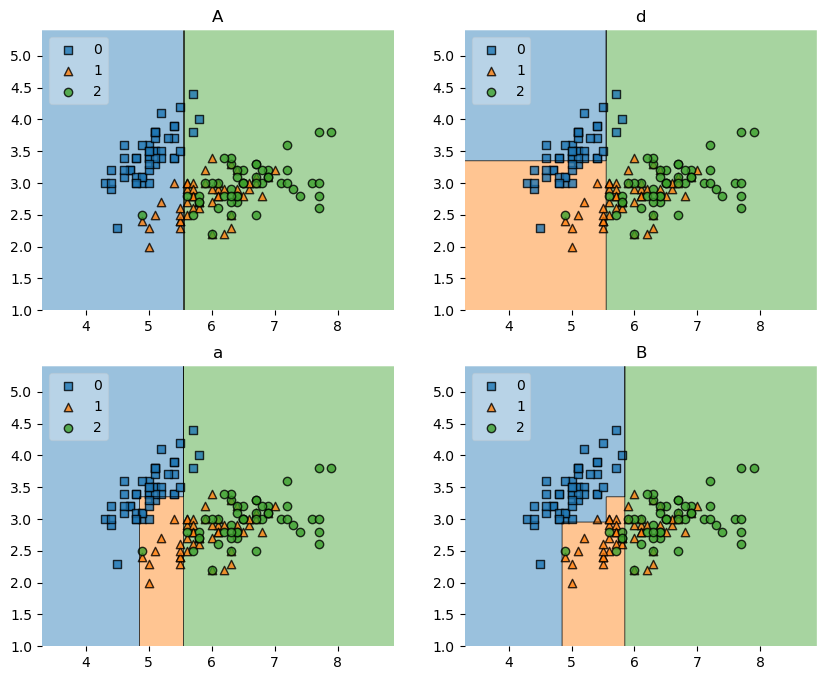

In [24]:
# Создаем фигуру размером 10 на 8 дюймов
fig = plt.figure(figsize=(10, 8))

# Создаем сетку 2x2 для размещения подграфиков
gs = gridspec.GridSpec(2, 2)

# Генерируем все возможные комбинации для размещения подграфиков
grid = itertools.product([0, 1], repeat=2)

# Проходим по количеству базовых классификаторов, меткам и позициям на сетке
for n_est, label, grd in zip(num_est, label, grid):
    # Создаем классификатор AdaBoost с заданным количеством базовых классификаторов
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    
    # Обучаем классификатор на данных X и y
    boosting.fit(X, y)
    
    # Создаем подграфик в указанной позиции на сетке
    ax = plt.subplot(gs[grd[0], grd[1]])
    
    # Строим график областей принятия решений для обученного классификатора
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    
    # Устанавливаем заголовок для текущего подграфика
    plt.title(label)

# Отображаем все графики
plt.show()

Алгоритм AdaBoost иллюстрируется на рисунке выше. Каждый базовый классификатор представляет собой дерево решений глубиной $1, таким образом классифицируя данные на основе порога признака, который разделяет пространство на две области, отделенные линейной границей решения, параллельной одной из осей.

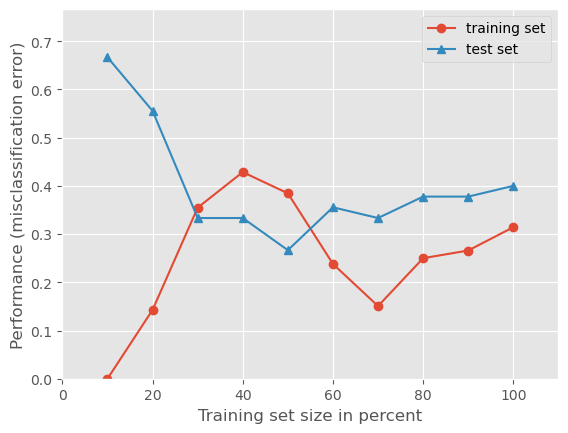

In [26]:
# Импорт необходимых библиотек
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

# Разделяем данные на обучающую и тестовую выборки (70% - обучение, 30% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем классификатор AdaBoost с базовым классификатором clf и 10 итерациями
boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)

# Создаем фигуру для графика
plt.figure()

# Строим кривые обучения, передавая обучающие и тестовые данные, классификатор и стиль графика
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')

# Отображаем график
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# Размер ансамбля
num_est = list(map(int, np.linspace(1, 100, 20)))  # Преобразуем в список
bg_clf_cv_mean = []  # Список для хранения среднего значения точности
bg_clf_cv_std = []   # Список для хранения стандартного отклонения точности

# Цикл по количеству базовых классификаторов
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)  # Создаем классификатор AdaBoost
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')  # Оцениваем модель с помощью кросс-валидации
    bg_clf_cv_mean.append(scores.mean())  # Добавляем среднее значение точности в список
    bg_clf_cv_std.append(scores.std())    # Добавляем стандартное отклонение точности в список

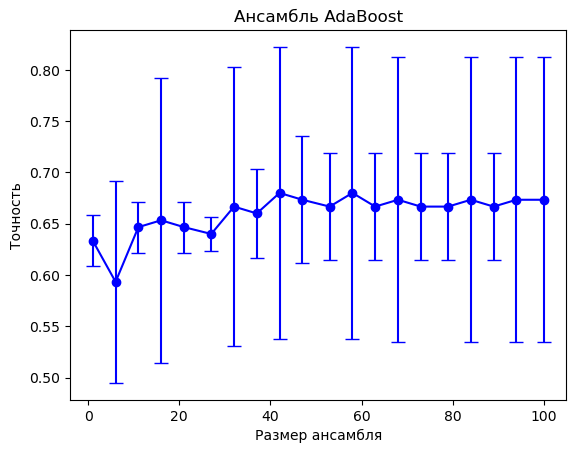

In [31]:
plt.figure()  # Создаем новую фигуру для графика
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)  # Строим график с ошибками
for cap in caps:
    cap.set_markeredgewidth(1)  # Устанавливаем ширину границ маркеров ошибок

# Подписываем оси и заголовок графика
plt.ylabel('Точность')
plt.xlabel('Размер ансамбля')
plt.title('Ансамбль AdaBoost')
plt.show()  # Отображаем график

На рисунке выше показано, как точность тестирования улучшается с увеличением размера ансамбля.

**Градиентный бустинг деревьев** — это обобщение бустинга для произвольных дифференцируемых функций ошибки. Он может использоваться как для задач регрессии, так и для задач классификации.

### Stacking

**Стекинг** — это техника ансамблевого обучения, которая объединяет несколько моделей классификации или регрессии с помощью мета-классификатора или мета-регрессора. Модели базового уровня обучаются на полном обучающем наборе, после чего мета-модель обучается на выходах моделей базового уровня, которые используются в качестве признаков. Модели базового уровня часто состоят из различных алгоритмов обучения, поэтому ансамбли стекинга часто являются гетерогенными.

In [33]:
# Импортируем необходимые библиотеки
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Импортируем наборы данных из sklearn
from sklearn import datasets

# Импортируем различные модели классификации из sklearn
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.neighbors import KNeighborsClassifier    # Метод k ближайших соседей
from sklearn.naive_bayes import GaussianNB            # Наивный байесовский классификатор
from sklearn.ensemble import RandomForestClassifier    # Случайный лес
from mlxtend.classifier import StackingClassifier      # Классификатор стекинга

# Импортируем функции для кросс-валидации и разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import cross_val_score, train_test_split

# Импортируем функции для построения графиков кривых обучения и областей решений
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [35]:
# Загружаем набор данных Ирисы
iris = datasets.load_iris()

# Извлекаем характеристики (X) и целевую переменную (y)
# Используем только 2 признака: 1-й и 2-й (индексы 1 и 2)
X, y = iris.data[:, 1:3], iris.target

# Создаем классификатор K ближайших соседей с 1 соседом
clf1 = KNeighborsClassifier(n_neighbors=1)

# Создаем классификатор случайного леса с фиксированным состоянием случайности
clf2 = RandomForestClassifier(random_state=1)

# Создаем наивный байесовский классификатор
clf3 = GaussianNB()

# Создаем логистическую регрессию
lr = LogisticRegression()

# Создаем классификатор стекинга, который объединяет несколько классификаторов
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)  # Используем логистическую регрессию как мета-классификатор

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [Stacking Classifier]


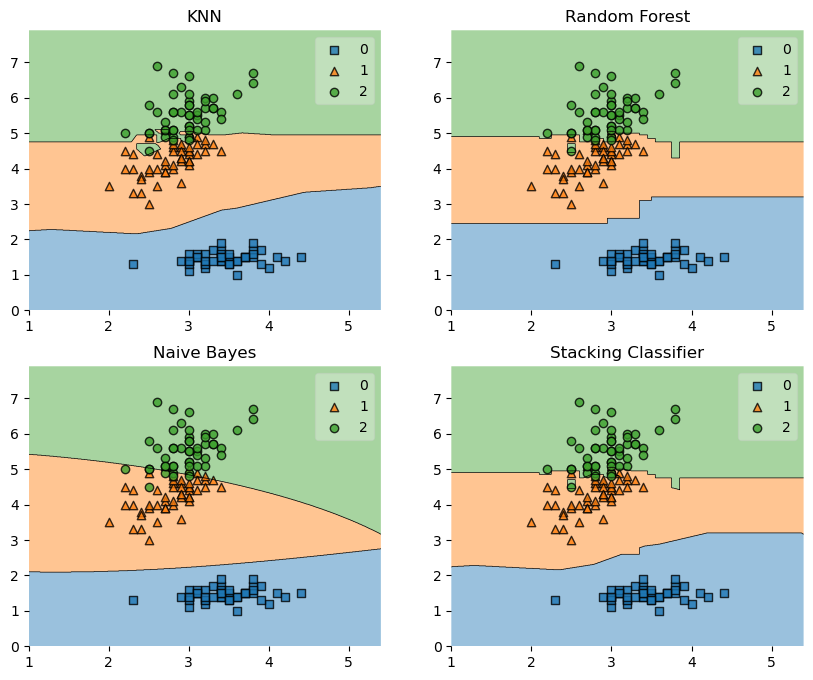

In [38]:
# Определяем метки для классификаторов
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']

# Список классификаторов
clf_list = [clf1, clf2, clf3, sclf]

# Создаем фигуру для графиков размером 10x8 дюймов
fig = plt.figure(figsize=(10, 8))

# Создаем сетку для размещения подграфиков (2 строки и 2 столбца)
gs = gridspec.GridSpec(2, 2)

# Генерируем все возможные пары индексов для подграфиков
grid = itertools.product([0, 1], repeat=2)

# Списки для хранения средних значений и стандартных отклонений точности
clf_cv_mean = []
clf_cv_std = []

# Проходим по каждому классификатору, метке и позиции в сетке
for clf, label, grd in zip(clf_list, label, grid):
    
    # Оцениваем классификатор с помощью перекрестной проверки (3 фолда) по метрике точности
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    # Выводим среднюю точность и стандартное отклонение для текущего классификатора
    print("Accuracy: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    # Добавляем среднюю точность и стандартное отклонение в соответствующие списки
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
    
    # Обучаем классификатор на всем наборе данных
    clf.fit(X, y)
    
    # Создаем подграфик для визуализации границ решения
    ax = plt.subplot(gs[grd[0], grd[1]])
    
    # Строим график границ решения для текущего классификатора
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    
    # Устанавливаем заголовок подграфика с названием классификатора
    plt.title(label)

# Отображаем все графики
plt.show()

Ансамбль стекинга иллюстрирован на рисунке выше. Он состоит из базовых классификаторов k-NN, Random Forest и Naive Bayes, чьи предсказания объединяются с помощью логистической регрессии в качестве мета-классификатора. Мы можем наблюдать смешение границ решений, достигнутое с помощью классификатора стекинга.

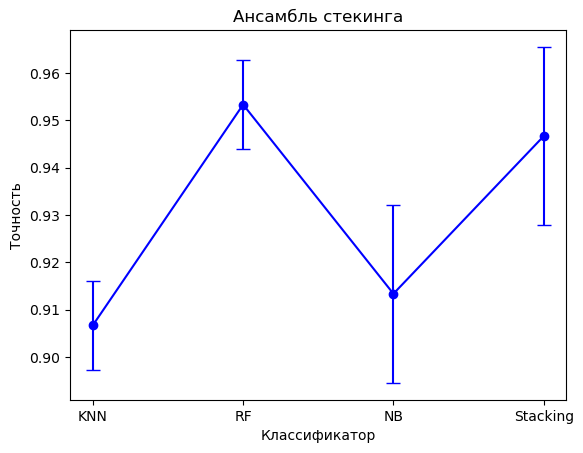

In [40]:
# Построение графика точности классификаторов
plt.figure()

# Отображение средних значений точности классификаторов с ошибками
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)

# Установка ширины границ для капсул ошибок
for cap in caps:
    cap.set_markeredgewidth(1)

# Установка меток по оси X для каждого классификатора
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])

# Подпись оси Y
plt.ylabel('Точность')

# Подпись оси X
plt.xlabel('Классификатор')

# Заголовок графика
plt.title('Ансамбль стекинга')

# Отображение графика
plt.show()


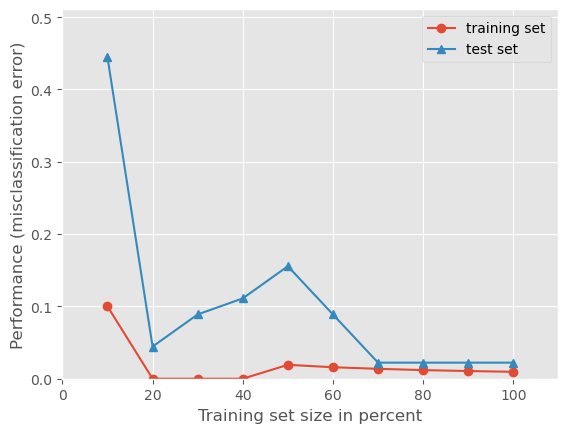

In [41]:
# Построение кривых обучения
# Разделение данных на обучающую и тестовую выборки (70% - обучение, 30% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание новой фигуры для графика
plt.figure()

# Вызов функции для построения кривых обучения с использованием обучающей и тестовой выборок
# sclf - это классификатор, который мы хотим оценить
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')

# Отображение графика
plt.show()

Мы можем видеть, что стекинг достигает более высокой точности, чем отдельные классификаторы, и на основании кривых обучения он не показывает признаков переобучения.